# **Set according to environment (e.g. local, Google Colab...)**

In [1]:
project_folder = ''

# **Body**

In [2]:
from custom_libraries.miscellaneous import progress_bar
from custom_libraries.image_dataset import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
bs = 256
weighting = 'paired'
trials = 10
classes = 10

ds_set = ['mnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']

paired_test = np.zeros((len(ds_set), trials, classes, classes))
heatmap_matrix = np.zeros((len(ds_set), classes, classes))

#paired_test = np.load(project_folder + 'results/confused_pairs_all.npy', allow_pickle=True)
#heatmap_matrix = np.load()

for k, ds in enumerate(ds_set):

    print(f"- Dataset: {ds}")
    test_ds = ImageDataset(ds, 'test', data_dir=None, USPS_dir=project_folder+'USPS/')
    train_ds = ImageDataset(ds, 'train', data_dir=None, USPS_dir=project_folder+'USPS/')

    for x in [train_ds, test_ds]:
        x.shuffle()
        x.normalize()
        if x.images.shape[1:3] == (28, 28):
            x.pad()
        x.vectorize(True)

    for t1 in range(10):
        for t2 in range(t1 + 1, 10):

            finished = False

            while not finished:

              try:

                progress_bar(0, max = 10, pre = f"-- Pair {t1} - {t2}:\t")
                train_ds.shuffle()
                test_ds.shuffle()
                X_test, y_test = test_ds.filter(t1, t2)
                X_train, y_train = train_ds.filter(t1, t2)
                # Per coerenza con Jones&Kording
                train_len = len(X_train)-len(X_test)
                X_train, y_train = [X_train[i] for i in range(train_len)], [y_train[i] for i in range(train_len)]

                X_train = np.array_split(X_train, trials)
                y_train = np.array_split(y_train, trials)

                average_acc = 0

                for m in range(trials):

                    lda = LinearDiscriminantAnalysis()
                    lda.fit(X_train[m], y_train[m])
                    score_test = lda.score(X_test, y_test)

                    paired_test[k, m, t1, t2] = score_test
                    average_acc = average_acc + score_test

                    progress_bar(m+1, max = 10, pre = f"-- Pair {t1} - {t2}:\t")

                heatmap_matrix[k][t1][t2], heatmap_matrix[k][t2][t1] = average_acc / trials, average_acc / trials

                progress_bar(10, max = 10, pre = f"-- Pair {t1} - {t2}:\t", post = f"\tAccuracy = {heatmap_matrix[k][t1][t2]}")
                print()

                np.save(project_folder + 'results/confused_pairs_all.npy', paired_test)
                np.save(project_folder + 'results/confused_pairs_matrix.npy', heatmap_matrix)

                finished = True

              except:

                print("\nAn error occurred. Repeating the pair.")

- Dataset: mnist
-- Pair 0 - 1:	[====================] 100%	Accuracy = 0.9786288416075649
-- Pair 0 - 2:	[====================] 100%	Accuracy = 0.949652087475149
-- Pair 0 - 3:	[====================] 100%	Accuracy = 0.9634170854271357
-- Pair 0 - 4:	[====================] 100%	Accuracy = 0.968960244648318
-- Pair 0 - 5:	[====================] 100%	Accuracy = 0.9463675213675213
-- Pair 0 - 6:	[====================] 100%	Accuracy = 0.94453044375645
-- Pair 0 - 7:	[====================] 100%	Accuracy = 0.9640438247011953
-- Pair 0 - 8:	[====================] 100%	Accuracy = 0.9600818833162743
-- Pair 0 - 9:	[====================] 100%	Accuracy = 0.9596279537456007
-- Pair 1 - 2:	[====================] 100%	Accuracy = 0.9156437471158284
-- Pair 1 - 3:	[====================] 100%	Accuracy = 0.9552447552447554
-- Pair 1 - 4:	[====================] 100%	Accuracy = 0.956967406707605
-- Pair 1 - 5:	[====================] 100%	Accuracy = 0.9493833251110015
-- Pair 1 - 6:	[====================] 1

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Lorenzo Petrella\tensorflow_datasets\svhn_cropped\3.0.0.incomplete3886IY\svhn_cropped-train…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Lorenzo Petrella\tensorflow_datasets\svhn_cropped\3.0.0.incomplete3886IY\svhn_cropped-test.…

Generating extra examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Lorenzo Petrella\tensorflow_datasets\svhn_cropped\3.0.0.incomplete3886IY\svhn_cropped-extra…

Dataset svhn_cropped downloaded and prepared to C:\Users\Lorenzo Petrella\tensorflow_datasets\svhn_cropped\3.0.0. Subsequent calls will reuse this data.
-- Pair 0 - 1:	[====================] 100%	Accuracy = 0.635452287008622
-- Pair 0 - 2:	[====================] 100%	Accuracy = 0.5762939080264721
-- Pair 0 - 3:	[====================] 100%	Accuracy = 0.5432555123216601
-- Pair 0 - 4:	[====================] 100%	Accuracy = 0.550667916569018
-- Pair 0 - 5:	[====================] 100%	Accuracy = 0.5355620155038758
-- Pair 0 - 6:	[====================] 100%	Accuracy = 0.533378124160172
-- Pair 0 - 7:	[====================] 100%	Accuracy = 0.5281690140845071
-- Pair 0 - 8:	[====================] 100%	Accuracy = 0.5292009400705052
-- Pair 0 - 9:	[====================] 100%	Accuracy = 0.5247678945792155
-- Pair 1 - 2:	[====================] 100%	Accuracy = 0.5276384083044983
-- Pair 1 - 3:	[====================] 100%	Accuracy = 0.5621350707931337
-- Pair 1 - 4:	[====================] 100%	Accu

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Lorenzo Petrella\tensorflow_datasets\cifar10\3.0.2.incompleteFR5855\cifar10-train.tfrecord*…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Lorenzo Petrella\tensorflow_datasets\cifar10\3.0.2.incompleteFR5855\cifar10-test.tfrecord*.…

Dataset cifar10 downloaded and prepared to C:\Users\Lorenzo Petrella\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.
-- Pair 0 - 1:	[====================] 100%	Accuracy = 0.6717000000000001
-- Pair 0 - 2:	[====================] 100%	Accuracy = 0.64165
-- Pair 0 - 3:	[====================] 100%	Accuracy = 0.6628499999999999
-- Pair 0 - 4:	[====================] 100%	Accuracy = 0.7049
-- Pair 0 - 5:	[====================] 100%	Accuracy = 0.6787999999999998
-- Pair 0 - 6:	[====================] 100%	Accuracy = 0.7468
-- Pair 0 - 7:	[====================] 100%	Accuracy = 0.6676
-- Pair 0 - 8:	[====================] 100%	Accuracy = 0.57935
-- Pair 0 - 9:	[====================] 100%	Accuracy = 0.6622
-- Pair 1 - 2:	[====================] 100%	Accuracy = 0.6953
-- Pair 1 - 3:	[====================] 100%	Accuracy = 0.66515
-- Pair 1 - 4:	[====================] 100%	Accuracy = 0.7112
-- Pair 1 - 5:	[====================] 100%	Accuracy = 0.6960500000000001
-- Pair 1 - 6

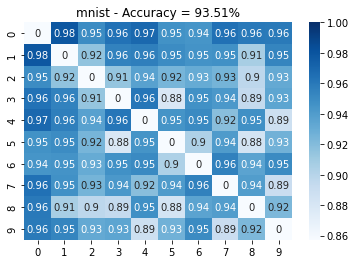

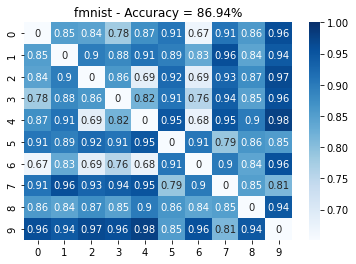

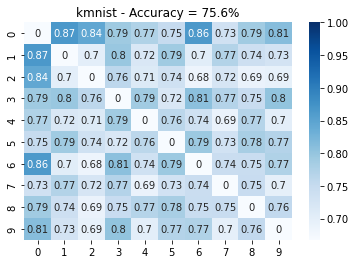

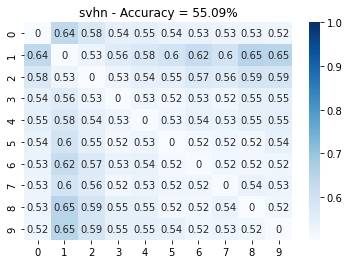

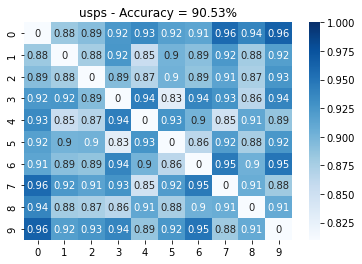

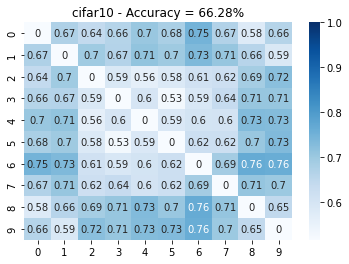

In [4]:
# Plotto heatmap matrix

heatmap_matrix = np.load(project_folder + 'results/confused_pairs_matrix.npy')
ds_set = ['mnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']

for k in range(len(ds_set)):
    heat = heatmap_matrix[k]
    min_acc = .975 * min(heat[np.nonzero(heat)])
    plt.figure()
    ax = sns.heatmap(heat, annot=True, cmap='Blues', vmin = min_acc, vmax = 1)
    ax.set_title(ds_set[k]+f" - Accuracy = {round(np.mean(heat[np.nonzero(heat)])*100, 2)}%")